# 疫学的因果関係
統計学が物的証拠として使われる代表例としては法律の決定や他何らかのトラブルに対する因果関係を証明するために疫学的因果関係を推定する。ここで、疫学的因果関係は7つの構成要素がある。本項では7つの構成要素の中で「一致性」「整合性」「必要条件」「十分条件」以外についての文面をそのままプログラムとして実装する。

また、疫学における因果関係はその専門分野の知識を多く持っていなくても使用できるメリットがあるため、研究活動において最初の頃には役に立ちやすい。

なお、適切なデータセットが見つからなかったため項目によって使用するデータセットを変えている。

参考1：https://chuo-kentetsu.co.jp/cgk/topix/tecrep30.pdf

参考2：https://apps.who.int/iris/bitstream/handle/10665/43541/9241547073_jpn.pdf


## ライブラリのインポート

In [1]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 順序関係
原因と結果についての順序関係を正しく把握する。例えばX→Yが正しいのかY→Xが正しいかなど、ある事象に対する因果関係における順序について考察する。

ここでは一例としてゴルフの来場について、天気が原因でゴルフを結果として考えてどの天気の時にゴルフをするか、また結果と原因の順序が変わることで数値の変動を確認する。

### データの確認

In [2]:
df = pd.read_csv("golf.csv", encoding="shift-jis")
df.head()

,天気,気温,湿度,風,ゴルフ
0,晴,29,85,弱,しない
1,晴,27,90,強,しない
2,曇,28,78,弱,する
3,雨,21,96,弱,する
4,雨,20,80,弱,する


### ベイズの定理で原因と結果の確率を計算する

In [3]:
x_name = "天気"
y_name = "ゴルフ"

In [4]:
x_val = list(set(df[x_name].values.tolist()))
for x in x_val:
    dfx = df.query("%s=='%s'"%(x_name, x))
    y_val = list(set(dfx[y_name].values.tolist()))
    for y in y_val:
        dfxy = dfx.query("%s=='%s'"%(y_name, y))
        print("p(%s=%s | %s=%s) = %.2f"%(y_name, y, x_name, x, len(dfxy)/len(dfx)))

p(ゴルフ=しない | 天気=晴) = 0.60
p(ゴルフ=する | 天気=晴) = 0.40
p(ゴルフ=しない | 天気=雨) = 0.40
p(ゴルフ=する | 天気=雨) = 0.60
p(ゴルフ=する | 天気=曇) = 1.00


In [5]:
y_val = list(set(df[y_name].values.tolist()))
for y in y_val:
    dfy = df.query("%s=='%s'"%(y_name, y))
    x_val = list(set(dfy[x_name].values.tolist()))
    for x in x_val:
        dfyx = dfy.query("%s=='%s'"%(x_name, x))
        print("p(%s=%s | %s=%s) = %.2f"%(x_name, x, y_name, y, len(dfyx)/len(dfy)))

p(天気=晴 | ゴルフ=しない) = 0.60
p(天気=雨 | ゴルフ=しない) = 0.40
p(天気=晴 | ゴルフ=する) = 0.22
p(天気=曇 | ゴルフ=する) = 0.44
p(天気=雨 | ゴルフ=する) = 0.33


### 結果の解釈
この結果から曇が原因でゴルフを行う事が結果になることが分かる。元々100%だった「曇→ゴルフ」が「ゴルフ→曇」にした場合は44%に変動し、曇が順序として原因と分かる。

## 量反応関係
調べたい量的変数を選び相関係数を求める。ただし、条件によって変わる可能性を考慮して質的変数で条件を絞り、それによって相関に違いが現れるかを確認する。また、ロジスティック回帰で係数からオッズ比を計算する事で各項目の量的な判別基準を算出して特徴を把握する。

ここでは一例としてアヤメの花の可弁の長さとがくの長さに関する相関について品種ごとに分けて計測する。

### データの確認

In [6]:
df = pd.read_csv("iris.csv")
df.head()

,category,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


### オッズ比

In [7]:
y_name = "category"
y = df[y_name].values
x_table = df.drop(y_name, axis=1)
x_name = x_table.columns
x = x_table.values
model = LR()
model.fit(x, y)
coef = model.coef_
coef = np.vstack((coef, np.exp(coef)))
col = []
for v in (list(set(y))):
    col.append("%dの回帰係数"%(v))
for v in (list(set(y))):
    col.append("%dのオッズ比"%(v))
df_coef = pd.DataFrame(coef.T)
df_coef.columns = col
df_coef.index = x_name
df_coef

,0の回帰係数,1の回帰係数,2の回帰係数,0のオッズ比,1のオッズ比,2のオッズ比
sepal length (cm),-0.423395,0.534093,-0.110698,0.654820,1.705901,0.895209
sepal width (cm),0.961689,-0.317924,-0.643765,2.616112,0.727658,0.525311
petal length (cm),-2.519421,-0.205372,2.724794,0.080506,0.814344,15.253267
petal width (cm),-1.086077,-0.939581,2.025658,0.337538,0.390792,7.581094


### 結果の解釈
基本的にがくの長さと花弁の長さは相関関係にある事が分かる。しかし品種「0」の時に相関が弱いため、品種「0」の場合に相関が働かない何らかの要因があると考えられる。

また、オッズ比から数値の反応を考慮すると、品種「0」ではどちらも長さは1より小さく一方で「1」と品種「2」はどちらかが1を上回ることが分かる。

## 強固性
リスク比が大きく原因と結果の強い関連性が高い場合は当該要因が原因である可能性がある。そこで、強固性の基準としては相対危険度を用いる。

ここでは一例として米国メリーランド州の刑務所から釈放され釈放後に一年間追跡調査された受刑者に関するデータから労働経験の有無(1：有、0：無)と逮捕の有無(1：有、0：無)で相対危険度を算出する。

### データの確認

In [8]:
df = pd.read_csv("rossi.csv")
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


### 相対危険度の算出

In [9]:
cross = pd.crosstab(df["wexp"], df["arrest"])
cross

arrest,0,1
wexp,,
0,123,62
1,195,52


In [10]:
aw = cross.values
print("相対危険度：%.2f"%((aw[0][1]/sum(aw[0]))/((aw[1][1]/sum(aw[1])))))

相対危険度：1.59


### 結果の解釈
相対危険度から労働経験がない人は労働経験がある人に比べて1.59倍逮捕されていることが確認できる。そのため、労働しない事によって何らかの犯罪の原因が発生する事が考えられる。

# 統計的因果推論
ここからは効果検証の方法として統計的な因果推論の仕方をいくつか紹介する。

In [11]:
df = pd.read_csv("rel.csv")
df.head()

,y,x,t,y_t1,y_t0
0,10,12,0,15,10
1,16,15,1,16,11
2,15,21,0,20,15
3,4,0,1,4,0
4,7,3,1,7,2


- y:今季の受注件数
- x:前季の受注件数
- t:分析レポートが提供されたかどうかを表すダミー変数
- y_t1:分析レポートが提供された場合の今季の受注件数
- y_t0:分析レポートが提供されなかった場合の今季の受注件数

## ナイーブな比較
この比較は対象のデータの平均値を用いて比較する。ただしランダム割付が確認できないケースの前後比較による因果効果の推定には注意

In [12]:
print("y - x = %.3f"%(df["y"].mean()-df["x"].mean()))

y - x = -0.800


## ITEの計算
ITEは個体に対する処理の効果を表すため配列になる。

In [13]:
print(df["y_t1"]-df["y_t0"])

0     5
1     5
2     5
3     4
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
12    5
13    5
14    5
15    5
16    5
17    5
18    5
19    5
20    5
21    5
22    5
23    5
24    5
25    5
26    5
27    5
28    5
29    5
30    5
31    5
32    5
33    5
34    5
35    5
36    5
37    5
38    4
39    5
40    5
41    5
42    5
43    5
44    5
45    5
46    5
47    5
48    5
49    5
50    5
51    5
52    5
53    5
54    5
55    5
56    5
57    5
58    5
59    5
dtype: int64


## ATEの計算
ATEは平均処置効果といい、注目する群全体における処理の効果を指す。

In [14]:
print("t1 - t0 = %.3f"%(df["y_t1"].mean()-df["y_t0"].mean()))

t1 - t0 = 4.967


## ATTの計算
今度は条件を絞って因果推論の計算を行う。その中で処置群(tが1)の場合における平均効果を計算する。

In [15]:
df_t1 = df.query("t==1")
print("t1 - t0 = %.3f"%(df_t1["y_t1"].mean()-df_t1["y_t0"].mean()))

t1 - t0 = 4.920


## ATUの計算
次に対照群(tが0)として介入をしなかった場合における平均効果を計算する。

In [16]:
df_t0 = df.query("t==0")
print("t1 - t0 = %.3f"%(df_t0["y_t1"].mean()-df_t0["y_t0"].mean()))

t1 - t0 = 5.000


## 有意差の検証
データについてここまで因果推論の計算として平均値で計算をしてきたが、その平均値の差が有意なのかについても検証しないといけない。そこでt検定を行う。

ここでは同一群であることに注意する。

In [17]:
import scipy.stats as stats

In [18]:
print("naive : %.3f"%(stats.ttest_rel(df["y"], df["x"])[1]))
print("ATE   : %.3f"%(stats.ttest_rel(df["y_t1"], df["y_t0"])[1]))
print("ATT   : %.3f"%(stats.ttest_rel(df_t1["y_t1"], df_t1["y_t0"])[1]))
print("ATU   : %.3f"%(stats.ttest_rel(df_t0["y_t1"], df_t0["y_t0"])[1]))

naive : 0.057
ATE   : 0.000
ATT   : 0.000
ATU   : 0.000


## DID
差分の差分法をDIDという。ここでは分析レポートが提供されたことについての効果検証を行う。

In [19]:
did = (df_t1["y_t1"].mean()-df_t1["y_t0"].mean()) - (df_t0["y_t1"].mean()-df_t0["y_t0"].mean())
print("DID:%.3f"%(did))

DID:-0.080


## 図示
ここまで数値で因果推論をしてきたが、これだけでは平均値の数値のみで分布が分かるわけではないし尺度も分かりずらい。そこでボックスプロットと折れ線グラフで図示する。

In [20]:
import matplotlib.pyplot as plt

### ナイーブな比較

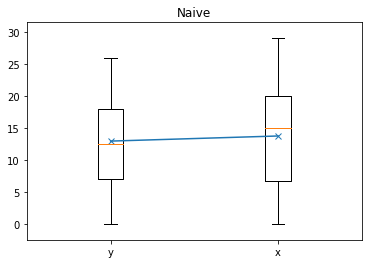

In [21]:
plt.boxplot([df["y"], df["x"]], positions=[0, 1], labels=["y", "x"])
plt.plot([0, 1], [df["y"].mean(), df["x"].mean()], marker="x")
plt.title("Naive")
plt.ylim(min(df.values.flatten())-2.5, max(df.values.flatten()+2.5))
plt.show()

### ATE

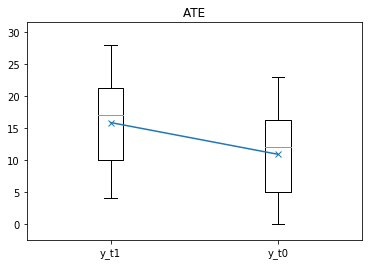

In [22]:
plt.boxplot([df["y_t1"], df["y_t0"]], positions=[0, 1], labels=["y_t1", "y_t0"])
plt.plot([0, 1], [df["y_t1"].mean(), df["y_t0"].mean()], marker="x")
plt.title("ATE")
plt.ylim(min(df.values.flatten())-2.5, max(df.values.flatten()+2.5))
plt.show()

### ATT

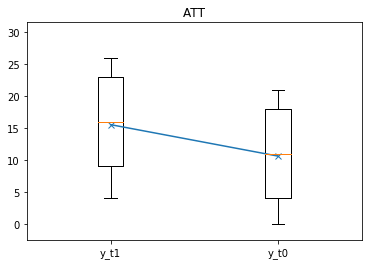

In [23]:
plt.boxplot([df_t1["y_t1"], df_t1["y_t0"]], positions=[0, 1], labels=["y_t1", "y_t0"])
plt.plot([0, 1], [df_t1["y_t1"].mean(), df_t1["y_t0"].mean()], marker="x")
plt.title("ATT")
plt.ylim(min(df.values.flatten())-2.5, max(df.values.flatten()+2.5))
plt.show()

### ATU

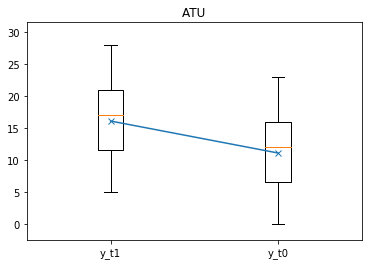

In [24]:
plt.boxplot([df_t0["y_t1"], df_t0["y_t0"]], positions=[0, 1], labels=["y_t1", "y_t0"])
plt.plot([0, 1], [df_t0["y_t1"].mean(), df_t0["y_t0"].mean()], marker="x")
plt.title("ATU")
plt.ylim(min(df.values.flatten())-2.5, max(df.values.flatten()+2.5))
plt.show()

### DID

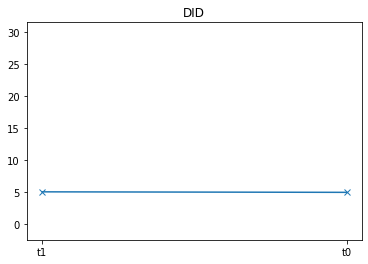

In [25]:
plt.plot([0, 1], [(df_t0["y_t1"].mean()-df_t0["y_t0"].mean()), (df_t1["y_t1"].mean()-df_t1["y_t0"].mean())], marker="x")
plt.title("DID")
plt.xticks([0, 1], ["t1", "t0"])
plt.ylim(min(df.values.flatten())-2.5, max(df.values.flatten()+2.5))
plt.show()

### 回帰不連続性

In [26]:
df = pd.read_csv("iris.csv")
df.head()

,category,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


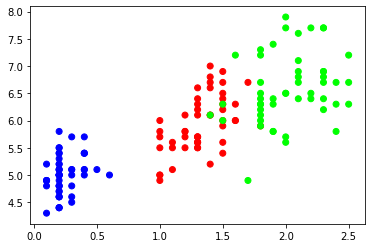

In [27]:
plt.scatter(df["petal width (cm)"], df["sepal length (cm)"], c=df["category"], cmap="brg")
plt.show()

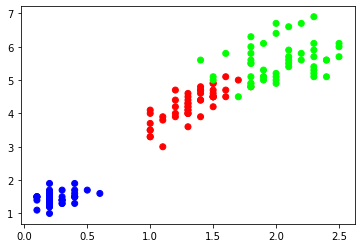

In [28]:
plt.scatter(df["petal width (cm)"], df["petal length (cm)"], c=df["category"], cmap="brg")
plt.show()

In [29]:
model10 = LinearRegression()
model10.fit(df.query("category==0")["petal width (cm)"].values.reshape(-1, 1), df.query("category==0")["sepal length (cm)"])
y_pred10 = model10.predict(df.query("category==0")["petal width (cm)"].values.reshape(-1, 1))
model11 = LinearRegression()
model11.fit(df.query("category==1")["petal width (cm)"].values.reshape(-1, 1), df.query("category==1")["sepal length (cm)"])
y_pred11 = model11.predict(df.query("category==1")["petal width (cm)"].values.reshape(-1, 1))
model12 = LinearRegression()
model12.fit(df.query("category==2")["petal width (cm)"].values.reshape(-1, 1), df.query("category==2")["sepal length (cm)"])
y_pred12 = model12.predict(df.query("category==2")["petal width (cm)"].values.reshape(-1, 1))

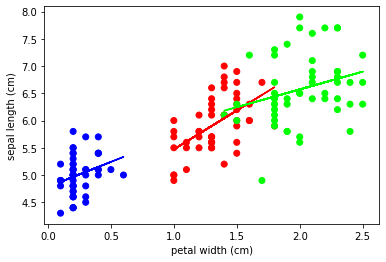

In [38]:
plt.scatter(df["petal width (cm)"], df["sepal length (cm)"], c=df["category"], cmap="brg")
plt.plot(df.query("category==0")["petal width (cm)"].values, y_pred10, color="#0000FF")
plt.plot(df.query("category==1")["petal width (cm)"].values, y_pred11, color="#FF0000")
plt.plot(df.query("category==2")["petal width (cm)"].values, y_pred12, color="#00FF00")
plt.xlabel("petal width (cm)")
plt.ylabel("sepal length (cm)")
plt.show()

In [31]:
print("y0 = %fx + %f"%(model10.coef_[0], model10.intercept_))
print("y1 = %fx + %f"%(model11.coef_[0], model11.intercept_))
print("y2 = %fx + %f"%(model12.coef_[0], model12.intercept_))

y0 = 0.917614x + 4.782102
y1 = 1.426365x + 4.044640
y2 = 0.650831x + 5.269417


この数式から考えるとy0とy2は近くy1とy0およびy1とy2は性質が遠い事が分かる。

In [32]:
model20 = LinearRegression()
model20.fit(df.query("category==0")["petal width (cm)"].values.reshape(-1, 1), df.query("category==0")["petal length (cm)"])
y_pred20 = model20.predict(df.query("category==0")["petal width (cm)"].values.reshape(-1, 1))
model21 = LinearRegression()
model21.fit(df.query("category==1")["petal width (cm)"].values.reshape(-1, 1), df.query("category==1")["petal length (cm)"])
y_pred21 = model21.predict(df.query("category==1")["petal width (cm)"].values.reshape(-1, 1))
model22 = LinearRegression()
model22.fit(df.query("category==2")["petal width (cm)"].values.reshape(-1, 1), df.query("category==2")["petal length (cm)"])
y_pred22 = model22.predict(df.query("category==2")["petal width (cm)"].values.reshape(-1, 1))

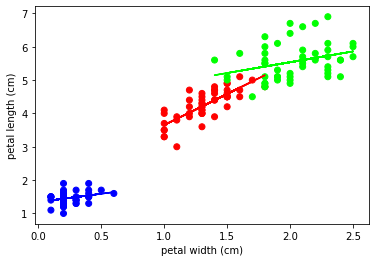

In [33]:
plt.scatter(df["petal width (cm)"], df["petal length (cm)"], c=df["category"], cmap="brg")
plt.plot(df.query("category==0")["petal width (cm)"].values, y_pred20, color="#0000FF")
plt.plot(df.query("category==1")["petal width (cm)"].values, y_pred21, color="#FF0000")
plt.plot(df.query("category==2")["petal width (cm)"].values, y_pred22, color="#00FF00")
plt.xlabel("petal width (cm)")
plt.ylabel("petal length (cm)")
plt.show()

In [34]:
print("y0 = %fx + %f"%(model20.coef_[0], model20.intercept_))
print("y1 = %fx + %f"%(model21.coef_[0], model21.intercept_))
print("y2 = %fx + %f"%(model22.coef_[0], model22.intercept_))

y0 = 0.495739x + 1.343040
y1 = 1.869325x + 1.781275
y2 = 0.647259x + 4.240653


散布図だけでは一見すると回帰が連続しているように見えるが、回帰式を算出すると必ず切片と勾配のどちらかが異なり同時に近似する事が無い事が分かる。
例えばy0とy2は勾配が似ているが切片は大きく異なり、y0とy1は切片が似ているが勾配は大きく異なる。